In [98]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html


In [99]:
import torch_geometric
import torch
from torch_geometric.utils import train_test_split_edges

data = dataset[0]
print(data)

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [100]:
data.is_undirected()
dataset = dataset.shuffle()
dataset = torch_geometric.datasets.Planetoid(root='data', name='PubMed')

perm = torch.randperm(len(dataset))
dataset = dataset[perm]
print(dataset)

train = dataset[:int(len(dataset)*0.8)]
test = dataset[int(len(dataset)*0.8):]

print(dataset.num_node_features)
print(dataset.data)


PubMed()
500
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [107]:
print(data.x)
print(data.x.shape)
print(len(data.x[0]))
print(data.edge_index)
print(data.edge_attr) ##need to add the vector embeddings as the edge attribuets
print(data.y) 


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


AttributeError: ignored

In [103]:
from itertools import chain
import numpy as np
import pandas as pd

edge_attributes = data.edge_index
print(edge_attributes)
num_edges = len(list(set(chain(*edge_attributes))))
print(num_edges)

all_nodes = len(data.x)
print(all_nodes)

np_table = np.zeros((all_nodes, all_nodes), dtype=int)
print(np_table.shape)

for idx in range(len(edge_attributes[0])):
  idx_1 = edge_attributes[0][idx]
  idx_2 = edge_attributes[1][idx]

  if np_table[idx_1][idx_2] != 1:
    np_table[idx_1][idx_2] = 1

# np_table.tofile('adjacency.csv', sep = ',')
# b = pd.DataFrame(np.asarray(data.x)).to_csv('features.csv')

tensor([[    0,     0,     0,  ..., 19714, 19715, 19716],
        [ 1378,  1544,  6092,  ..., 12278,  4284, 16030]])
177296
19717
(19717, 19717)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

graph = [(edge_attributes[0][x], edge_attributes[1][x]) for x in range(len(edge_attributes[0]))]
nodes = set(chain(*edge_attributes))



def draw_graph(graph):
  G = nx.Graph()

  nodes = set([int(n1) for n1, n2 in graph] + [int(n2) for n1, n2 in graph])

  for node in nodes: 
    G.add_node(node)
  
  for edge in graph:
    G.add_edge(int(edge[0]), int(edge[1]))
  
    pos = nx.shell_layout(G)
    nx.draw(G, pos)

  plt.show()
  

draw_graph(graph)


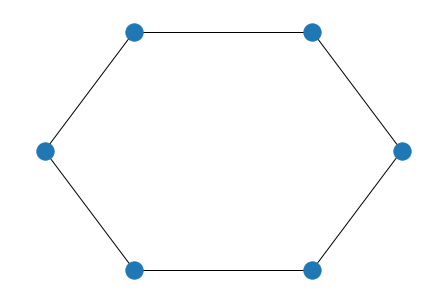

In [111]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph):

    # extract nodes from graph
    nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])

    # create networkx graph
    G=nx.Graph()

    # add nodes
    for node in nodes:
        G.add_node(node)

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # draw graph
    pos = nx.shell_layout(G)
    nx.draw(G, pos)

    # show graph
    plt.show()

# draw example
graph = [(20, 21),(21, 22),(22, 23), (23, 24),(24, 25), (25, 20)]
draw_graph(graph)

In [ ]:
import torch

data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)

class Net(torch.nn.Module):
  def __init__ (self):
    super(Net, self).__init__()
    self.conv1 = torch_geometric.nn.GCNConv(dataset.num_features, 256)
    self.conv2 = torch_geometric.nn.GCNConv(256, 128)
    self.conv3 = torch_geometric.nn.GCNConv(128, 64)

  def encode(self):
    x = self.conv1(data.x, data.pos_edge_index)
    x = x.relu()
    return self.conv2(x, data.pos_edge_index)
  
  def decode(self, z, pos_edge_index, neg_edge_index):
    edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
    logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)
    return logits

  def decode_all(self, z):
    prob_adj = z @ z.t()
    return (prob_adj > 0).nonzero(as_tuple=False).t()

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F

data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)

device = "cpu"


model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs


  
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))


z = model.encode()
final_edge_index = model.decode_all(z)


TypeError: ignored